# PM2.5 Prediction using Bidirectional LSTM

## Overview

This notebook implements a **LSTM model** for PM2.5 air quality prediction across multiple regions in Qatar. The model uses historical weather and air quality data to forecast PM2.5 concentrations.

### Objectives

-   Build a deep learning model to predict PM2.5 levels
-   Use time-series data from multiple Qatar regions
-   Implement autoregressive forecasting for future predictions

### Dataset

-   **Source:** Historical weather and air quality data
-   **Regions:** Doha, Khor, Qatar, Rayyan, Ummsalal, Wakrah
-   **Features:** Temperature, humidity, wind, NO₂, dust, aerosol optical depth

---

## 1. Environment Setup

### 1.1 Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import warnings
import os
from datetime import timedelta

### 1.2 Configuration

Setup environment settings:

-   Suppress warnings for cleaner output
-   Configure plotting style
-   Check GPU availability for faster training

In [2]:
warnings.filterwarnings("ignore")

plt.style.use('seaborn-v0_8-darkgrid')

print(f"TensorFlow Version: {tf.__version__}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is ready!")
else:
    print("Running on CPU")

TensorFlow Version: 2.19.0
GPU is ready!


---

## 2. Data Preparation

### 2.1 Load Data

Load the training dataset containing hourly measurements from all Qatar regions.

> **Note:** Data is sorted by `region` and `time` to ensure proper sequence generation without mixing data from different cities.

In [3]:
print("Loading FULL dataset...")
df = pd.read_csv('final_training_data_all_regions.csv')
df['time'] = pd.to_datetime(df['time'])

df = df.sort_values(by=['region', 'time'])

print(f"Total Rows: {len(df)}")

Loading FULL dataset...
Total Rows: 153936


### 2.2 Feature Engineering

Create cyclical time features and wind direction encoding to help the model understand temporal patterns.

**Time Features (Cyclical Encoding):**

-   `hour_sin`, `hour_cos` → Captures daily patterns (rush hour, night)
-   `month_sin`, `month_cos` → Captures seasonal patterns (summer dust, winter)

**Wind Direction Encoding:**

-   Convert degrees (0-360°) to sin/cos (-1 to 1)
-   Fixes the "360° jump" problem where 359° and 1° appear far apart

**Region Encoding:**

-   One-hot encoding for cities to allow the model to learn region-specific patterns

In [4]:
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)

wd_rad = df['wind_direction_10m (°)'] * np.pi / 180
df['wd_sin'] = np.sin(wd_rad)
df['wd_cos'] = np.cos(wd_rad)

df_encoded = pd.get_dummies(df, columns=['region'], prefix='city')

### 2.3 Define Features

Define the target variable and input features for the model.

| Feature Type    | Features                          |
| --------------- | --------------------------------- |
| **Target**      | PM2.5 concentration (μg/m³)       |
| **Weather**     | Temperature, Humidity, Wind Speed |
| **Air Quality** | NO₂, Dust, Aerosol Optical Depth  |
| **Temporal**    | Hour (sin/cos), Month (sin/cos)   |
| **Spatial**     | City one-hot encoding             |

In [5]:
target_col = 'pm2_5 (μg/m³)'

feature_cols = [
    'pm2_5 (μg/m³)',
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)',
    'wd_sin', 'wd_cos',
    'nitrogen_dioxide (μg/m³)',
    'dust (μg/m³)',
    'aerosol_optical_depth ()',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]
city_cols = [col for col in df_encoded.columns if col.startswith('city_')]
all_features = feature_cols + city_cols

print(f"Features Selected: {len(all_features)}")
print(f"Cities included: {city_cols}")

Features Selected: 19
Cities included: ['city_doha', 'city_khor', 'city_qatar', 'city_rayyan', 'city_ummsalal', 'city_wakrah']


### 2.4 Scaling

Apply **MinMaxScaler** to normalize all features to [0, 1] range.

> **Why scaling?** LSTM networks are sensitive to input scale. Normalization ensures:
>
> -   Faster convergence during training
> -   Equal importance to all features
> -   Stable gradient flow

In [6]:
scaler_X = MinMaxScaler()
X_data = scaler_X.fit_transform(df_encoded[all_features]).astype('float32')

scaler_y = MinMaxScaler()
y_data = scaler_y.fit_transform(df_encoded[[target_col]]).astype('float32')

### 2.5 Create Sequences

Generate time-series sequences for LSTM input.

**Configuration:**

-   `TIME_STEPS = 48` → Use 48 hours (2 days) of historical data
-   Each sequence predicts the PM2.5 value for the next hour

**Process:**

1. Group data by region to avoid mixing cities
2. Create sliding windows of 48 hours
3. Target is the PM2.5 value at hour 49
```

Input: [hour_1, hour_2, ..., hour_48] → Output: PM2.5 at hour_49

```

In [7]:
def create_sequences(data_df, x_scaled, y_scaled, time_steps):
    Xs, ys = [], []
    for region_name, group in data_df.groupby('region'):
        indices = group.index
        region_X = x_scaled[indices]
        region_y = y_scaled[indices]
        for i in range(len(region_X) - time_steps):
            Xs.append(region_X[i:(i + time_steps)])
            ys.append(region_y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 48
print("Creating sequences...")
X_seq, y_seq = create_sequences(df, X_data, y_data, TIME_STEPS)

print(f"Final Input Shape: {X_seq.shape}")

Creating sequences...
Final Input Shape: (153648, 48, 19)


### 2.6 Train/Test Split

Split data into training and testing sets.

| Set          | Percentage | Purpose                |
| ------------ | ---------- | ---------------------- |
| **Training** | 95%        | Model learning         |
| **Testing**  | 5%         | Performance evaluation |

> **Note:** We use a simple split (not random) to preserve temporal order, which is crucial for time-series data.

In [8]:
split = int(len(X_seq) * 0.95)
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")

Train samples: 145965 | Test samples: 7683


---

## 3. Model Development

### 3.1 Build Model

Construct a **Bidirectional LSTM** neural network.

**Architecture:**
```

Input (48 timesteps × 19 features)
↓
Bidirectional LSTM (128 units) → BatchNorm → Dropout(0.2)
↓
Bidirectional LSTM (64 units) → BatchNorm → Dropout(0.2)
↓
Dense (32 units, ReLU)
↓
Dense (1 unit) → PM2.5 Prediction

```

**Why Bidirectional LSTM?**
- Processes sequences in both forward and backward directions
- Captures patterns that depend on future context
- Better understanding of temporal dependencies

**Regularization:**
- `BatchNormalization` → Stabilizes training
- `Dropout(0.2)` → Prevents overfitting

In [9]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.Huber(),
              metrics=['mae', 'mse'])

### 3.2 Train Model

Train the model with optimized hyperparameters.

**Training Configuration:**
| Parameter | Value | Description |
|-----------|-------|-------------|
| Epochs | 50 | Maximum training iterations |
| Batch Size | 128 | Samples per gradient update |
| Validation Split | 10% | Data for monitoring overfitting |
| Optimizer | Adam | Adaptive learning rate |
| Learning Rate | 0.001 | Initial step size |
| Loss Function | Huber | Robust to outliers |

**Callbacks:**

-   `EarlyStopping` → Stop if no improvement for 15 epochs
-   `ReduceLROnPlateau` → Reduce learning rate when stuck

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

print("Training Model...")
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

model.save('lstm_model.keras')
print("Model saved.")

joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Scalers saved.")

# import gc
# gc.collect()
# tf.keras.backend.clear_session()

Training Model...
Epoch 1/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0636 - mae: 0.2291 - mse: 0.1419 - val_loss: 0.0032 - val_mae: 0.0636 - val_mse: 0.0063 - learning_rate: 0.0010
Epoch 2/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0022 - mae: 0.0497 - mse: 0.0044 - val_loss: 8.6020e-04 - val_mae: 0.0317 - val_mse: 0.0017 - learning_rate: 0.0010
Epoch 3/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0011 - mae: 0.0353 - mse: 0.0023 - val_loss: 5.9149e-04 - val_mae: 0.0278 - val_mse: 0.0012 - learning_rate: 0.0010
Epoch 4/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 8.1246e-04 - mae: 0.0302 - mse: 0.0016 - val_loss: 2.3167e-04 - val_mae: 0.0151 - val_mse: 4.6335e-04 - learning_rate: 0.0010
Epoch 5/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 5.6360e-04 - mae: 0.0250 - mse: 0.0011 - val_loss: 5.1672e-04 - val_mae: 0.0277 - val_mse: 0.0010 - learning_rate: 0.0010
Epoch 6/50
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 

---

## 4. Model Evaluation

### 4.1 Generate Predictions

Generate predictions on both training and test sets, then inverse transform to get actual PM2.5 values in μg/m³.

In [11]:
print("Generating predictions...")
y_train_pred_scaled = model.predict(X_train, verbose=0)
y_test_pred_scaled = model.predict(X_test, verbose=0)

y_train_actual = scaler_y.inverse_transform(y_train)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_test_actual = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

Generating predictions...


### 4.2 Calculate Metrics

Evaluate model performance using multiple metrics.

| Metric       | Description                    | Ideal Value     |
| ------------ | ------------------------------ | --------------- |
| **MAE**      | Mean Absolute Error            | Lower is better |
| **RMSE**     | Root Mean Squared Error        | Lower is better |
| **R² Score** | Coefficient of Determination   | Closer to 1     |
| **MAPE**     | Mean Absolute Percentage Error | Lower is better |

> **R² Score Interpretation:**
>
> -   `> 0.9` → Excellent
> -   `0.7 - 0.9` → Good
> -   `< 0.7` → Needs improvement

In [12]:
def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1))) * 100

    print(f"\n{dataset_name} Metrics:")
    print(f"  MAE: {mae:.2f} μg/m³")
    print(f"  RMSE: {rmse:.2f} μg/m³")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE (Inv Accuracy): {mape:.2f}%")

    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

print("-" * 50)
test_metrics = calculate_metrics(y_test_actual, y_test_pred, "Test Set")
print("-" * 50)

--------------------------------------------------

Test Set Metrics:
  MAE: 1.77 μg/m³
  RMSE: 2.78 μg/m³
  R² Score: 0.9656
  MAPE (Inv Accuracy): 5.38%
--------------------------------------------------


### 4.3 Visualization

Comprehensive visualization of model performance.

**Plots:**

1. **Training History** → Loss curves to detect overfitting
2. **Scatter Plot** → Actual vs Predicted correlation
3. **Time Series** → Visual comparison over time
4. **Error Distribution** → Histogram of prediction errors
5. **Zoomed Forecast** → Detailed view of predictions

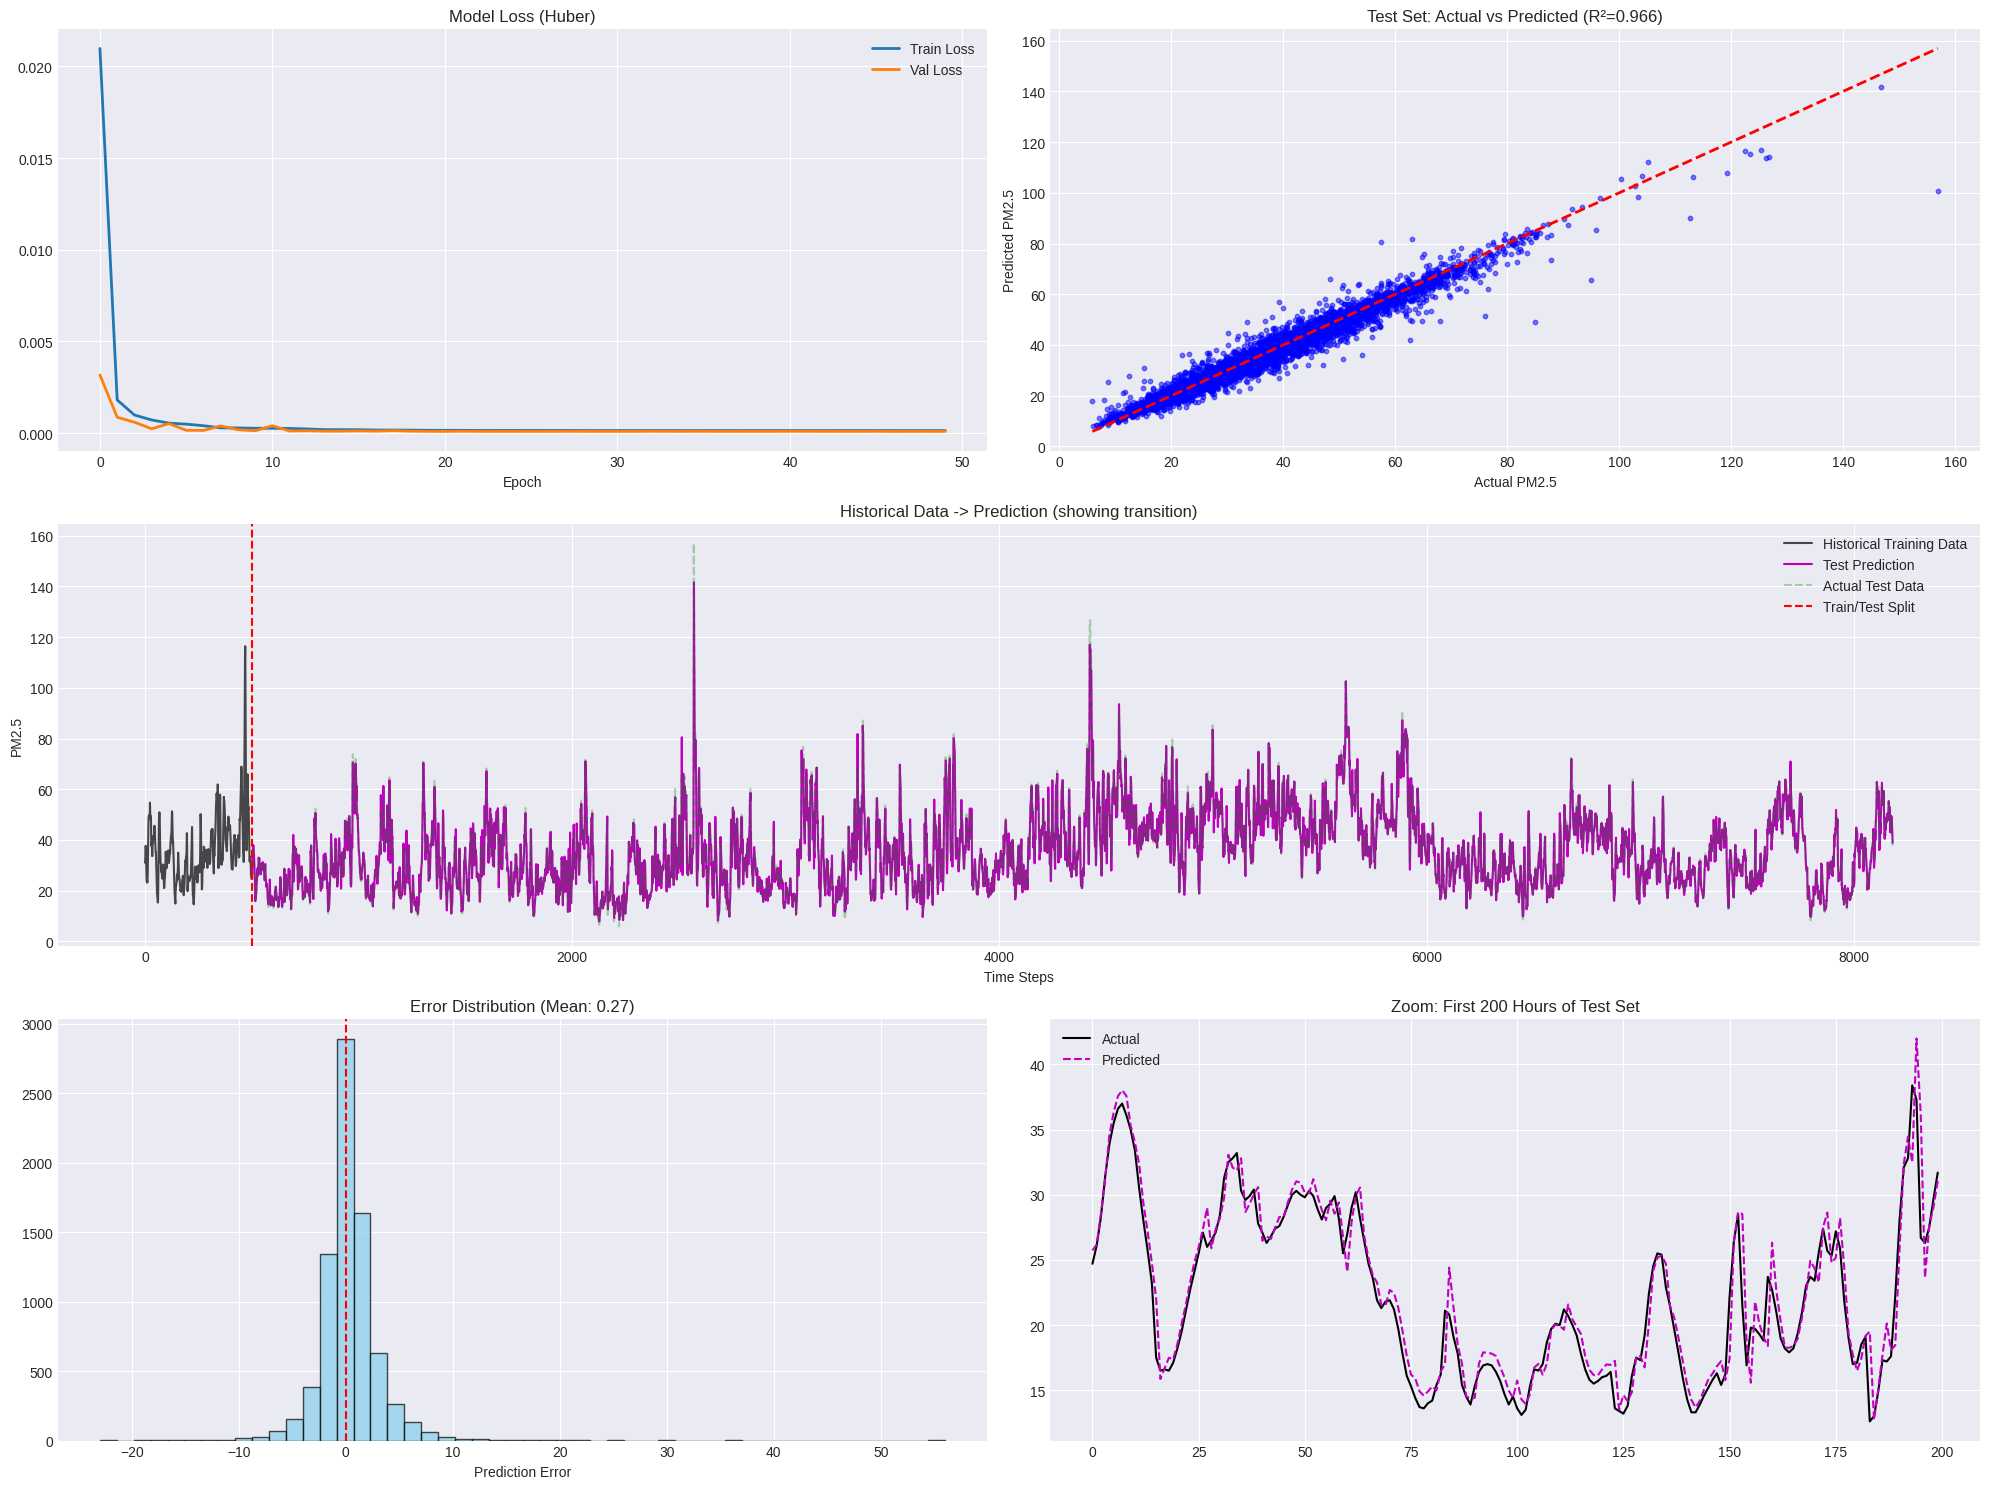

In [13]:
fig = plt.figure(figsize=(20, 15))

ax1 = plt.subplot(3, 2, 1)
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Model Loss (Huber)')
ax1.set_xlabel('Epoch')
ax1.legend()

ax2 = plt.subplot(3, 2, 2)
ax2.scatter(y_test_actual, y_test_pred, alpha=0.5, s=10, c='blue')
ax2.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()], 'r--', linewidth=2)
ax2.set_xlabel('Actual PM2.5')
ax2.set_ylabel('Predicted PM2.5')
ax2.set_title(f'Test Set: Actual vs Predicted (R²={test_metrics["r2"]:.3f})')

ax3 = plt.subplot(3, 1, 2)
display_len = 500

train_plot_data = y_train_actual[-display_len:]
test_pred_data = y_test_pred

x_train = range(len(train_plot_data))
x_test = range(len(train_plot_data), len(train_plot_data) + len(test_pred_data))

ax3.plot(x_train, train_plot_data, 'k-', label='Historical Training Data', alpha=0.7)
ax3.plot(x_test, test_pred_data, 'm-', label='Test Prediction', linewidth=1.5)
ax3.plot(x_test, y_test_actual, 'g--', label='Actual Test Data', alpha=0.3)

ax3.axvline(x=len(train_plot_data), color='r', linestyle='--', label='Train/Test Split')
ax3.set_title(f'Historical Data -> Prediction (showing transition)')
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('PM2.5')
ax3.legend()

ax4 = plt.subplot(3, 2, 5)
errors = y_test_actual - y_test_pred
ax4.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(x=0, color='r', linestyle='--')
ax4.set_title(f'Error Distribution (Mean: {errors.mean():.2f})')
ax4.set_xlabel('Prediction Error')

ax5 = plt.subplot(3, 2, 6)
ax5.plot(y_test_actual[:200], 'k-', label='Actual')
ax5.plot(y_test_pred[:200], 'm--', label='Predicted')
ax5.set_title('Zoom: First 200 Hours of Test Set')
ax5.legend()

plt.tight_layout()
plt.savefig('team_style_results.png')
plt.show()

---

## 5. Future Forecasting

### 5.1 Forecast Setup

Configure autoregressive forecasting for a specific city.

**Autoregressive Approach:**
The model uses its own predictions as input for future predictions.
```

Real Data [t-48 to t] → Predict t+1
Real Data [t-47 to t] + Pred[t+1] → Predict t+2
...and so on

```

**Configuration:**
- `FORECAST_HOURS = 24` → Predict next 24 hours
- `TARGET_CITY = Doha` → Focus on capital city

In [14]:
FORECAST_HOURS = 24
TARGET_CITY_PREFIX = 'city_doha'

print(f"Generating {FORECAST_HOURS}-hour Autoregressive Forecast for {TARGET_CITY_PREFIX}...")

city_df = df_encoded[df_encoded[TARGET_CITY_PREFIX] == 1].copy()
last_sequence_df = city_df.iloc[-TIME_STEPS:]
last_time = city_df['time'].iloc[-1]

print(f"Forecasting from: {last_time}")

current_batch = scaler_X.transform(last_sequence_df[all_features])
current_batch = current_batch.reshape(1, TIME_STEPS, len(all_features))

pm25_idx = all_features.index(target_col)
h_sin_idx = all_features.index('hour_sin')
h_cos_idx = all_features.index('hour_cos')

Generating 24-hour Autoregressive Forecast for city_doha...
Forecasting from: 2025-12-04 23:00:00


### 5.2 Forecast Loop

Execute the 24-hour autoregressive prediction loop.

**For each hour:**

1. Predict next PM2.5 value
2. Update PM2.5 input with predicted value
3. Update time features (hour_sin, hour_cos)
4. Slide the window forward
5. Repeat

> **Note:** Weather features (temperature, wind) remain constant as we don't have future weather forecasts.

In [15]:
future_predictions = []
future_dates = []
current_time = last_time

for i in range(FORECAST_HOURS):
    pred_scaled = model.predict(current_batch, verbose=0)

    pred_value = scaler_y.inverse_transform(pred_scaled)[0][0]
    future_predictions.append(pred_value)

    next_time = current_time + timedelta(hours=1)
    future_dates.append(next_time)

    next_features = current_batch[0, -1, :].copy()

    next_features[pm25_idx] = pred_scaled[0][0]

    next_features[h_sin_idx] = np.sin(2 * np.pi * next_time.hour / 24)
    next_features[h_cos_idx] = np.cos(2 * np.pi * next_time.hour / 24)

    next_features = next_features.reshape(1, 1, len(all_features))

    current_batch = np.append(current_batch[:, 1:, :], next_features, axis=1)

    current_time = next_time

print(f"Forecast Complete.")

Forecast Complete.


### 5.3 Forecast Visualization

Display the 24-hour forecast alongside historical data.

**Plot shows:**

-   **Black line:** Past 48 hours (actual data)
-   **Red dashed:** Future 24 hours (predictions)
-   **Blue vertical:** Current time marker

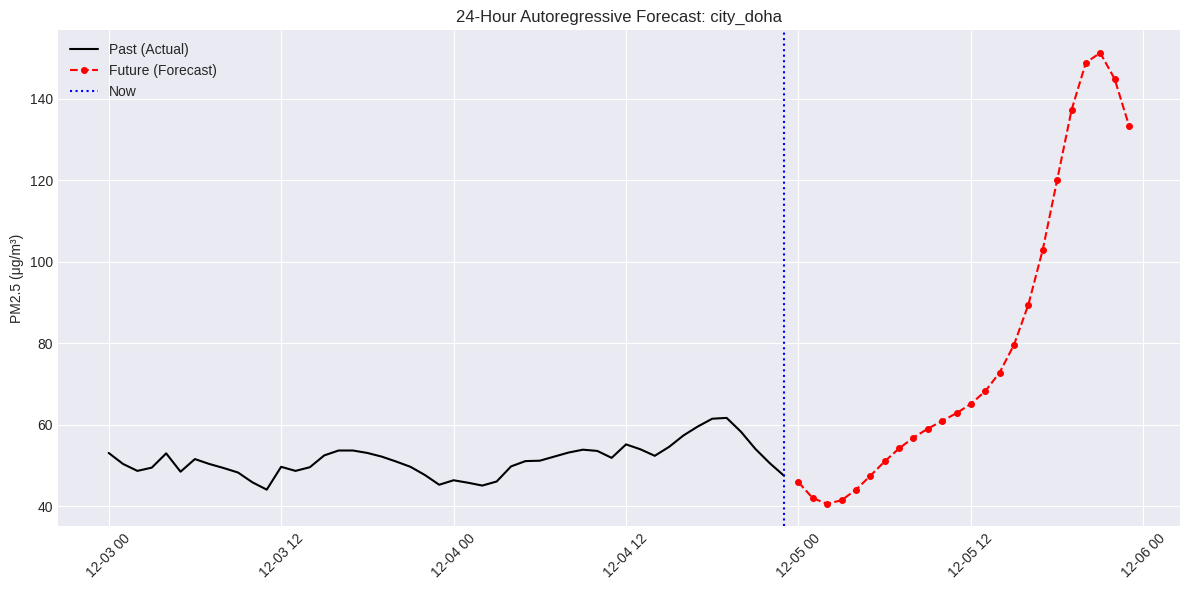

                  Time  Predicted_PM2.5
0  2025-12-05 00:00:00        45.916389
1  2025-12-05 01:00:00        41.992832
2  2025-12-05 02:00:00        40.625198
3  2025-12-05 03:00:00        41.505806
4  2025-12-05 04:00:00        44.071465
5  2025-12-05 05:00:00        47.487659
6  2025-12-05 06:00:00        51.020897
7  2025-12-05 07:00:00        54.201481
8  2025-12-05 08:00:00        56.859455
9  2025-12-05 09:00:00        59.046459
10 2025-12-05 10:00:00        60.953377
11 2025-12-05 11:00:00        62.864983
12 2025-12-05 12:00:00        65.138527
13 2025-12-05 13:00:00        68.251007
14 2025-12-05 14:00:00        72.833313
15 2025-12-05 15:00:00        79.653076
16 2025-12-05 16:00:00        89.501465
17 2025-12-05 17:00:00       102.964455
18 2025-12-05 18:00:00       120.057983
19 2025-12-05 19:00:00       137.182556
20 2025-12-05 20:00:00       148.855515
21 2025-12-05 21:00:00       151.254089
22 2025-12-05 22:00:00       144.873001
23 2025-12-05 23:00:00       133.424042


In [16]:
plt.figure(figsize=(12, 6))

history_hours = 48
plt.plot(city_df['time'].iloc[-history_hours:],
         city_df[target_col].iloc[-history_hours:],
         label='Past (Actual)', color='black', linewidth=1.5)

plt.plot(future_dates, future_predictions,
         label='Future (Forecast)', color='red', marker='o', markersize=4, linestyle='--')

plt.axvline(x=last_time, color='blue', linestyle=':', label='Now')
plt.title(f'24-Hour Autoregressive Forecast: {TARGET_CITY_PREFIX}')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

forecast_df = pd.DataFrame({'Time': future_dates, 'Predicted_PM2.5': future_predictions})
print(forecast_df.head(24))

---

## 6. Testing on New Data

Validate the trained model on a completely separate test dataset.

### 6.1 Test Configuration

Define paths and parameters for testing.

> **Important:** `TIME_STEPS` must match the training configuration (48).

In [17]:
MODEL_PATH = "lstm_model.keras"
TRAIN_FILE = "final_training_data_all_regions.csv"
TEST_FILE = "final_test_data_all_regions.csv"
TIME_STEPS = 48

### 6.2 Engineer Features Function

Reusable function to apply the same feature engineering to new data.

This ensures consistency between training and testing data transformations.

In [18]:
def engineer_features(df):
    df = df.copy()

    df['time'] = pd.to_datetime(df['time'])
    df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12)

    wd_rad = df['wind_direction_10m (°)'] * np.pi / 180
    df['wd_sin'] = np.sin(wd_rad)
    df['wd_cos'] = np.cos(wd_rad)

    df = pd.get_dummies(df, columns=['region'], prefix='city')

    return df

### 6.3 Load Model

Load the previously saved trained model from disk.

In [19]:
print(f"Loading model from: {MODEL_PATH}")
if os.path.exists(MODEL_PATH):
    model = keras.models.load_model(MODEL_PATH)
    print("Model loaded successfully!")
else:
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}")

Loading model from: lstm_model.keras
Model loaded successfully!


### 6.4 Prepare Scalers

Fit scalers using training data to ensure consistent normalization.

> **Critical:** Scalers must be fit on training data only, then applied to test data to prevent data leakage.

In [20]:
print("Loading Training Data to fit Scalers...")
df_train_raw = pd.read_csv(TRAIN_FILE)
df_train = engineer_features(df_train_raw)

target_col = 'pm2_5 (μg/m³)'
feature_cols = [
    'pm2_5 (μg/m³)',
    'temperature_2m (°C)',
    'relative_humidity_2m (%)',
    'wind_speed_10m (km/h)',
    'wd_sin', 'wd_cos',
    'nitrogen_dioxide (μg/m³)',
    'dust (μg/m³)',
    'aerosol_optical_depth ()',
    'hour_sin', 'hour_cos',
    'month_sin', 'month_cos'
]
city_cols = [col for col in df_train.columns if col.startswith('city_')]
all_features = feature_cols + city_cols

print(f"Total Features Expected: {len(all_features)}")

scaler_X = MinMaxScaler()
scaler_X.fit(df_train[all_features])

scaler_y = MinMaxScaler()
scaler_y.fit(df_train[[target_col]])

Loading Training Data to fit Scalers...
Total Features Expected: 19


MinMaxScaler()

### 6.5 Load Test Data

Load the separate test dataset and prepare for evaluation.

In [21]:
print(f"\nProcessing Test File: {TEST_FILE}")
df_test_raw = pd.read_csv(TEST_FILE)
df_test_raw['time'] = pd.to_datetime(df_test_raw['time'])

regions = df_test_raw['region'].unique()
global_actuals = []
global_preds = []


Processing Test File: final_test_data_all_regions.csv


### 6.6 Evaluate Regions

Evaluate model performance on each region separately.

**Process for each region:**

1. Get last 48 hours from training (context)
2. Combine with test data
3. Apply feature engineering
4. Create sequences and predict
5. Calculate metrics and visualize


Evaluating Region: DOHA...
  Predicting 144 hours...
  > R²: 0.9280 | RMSE: 2.63


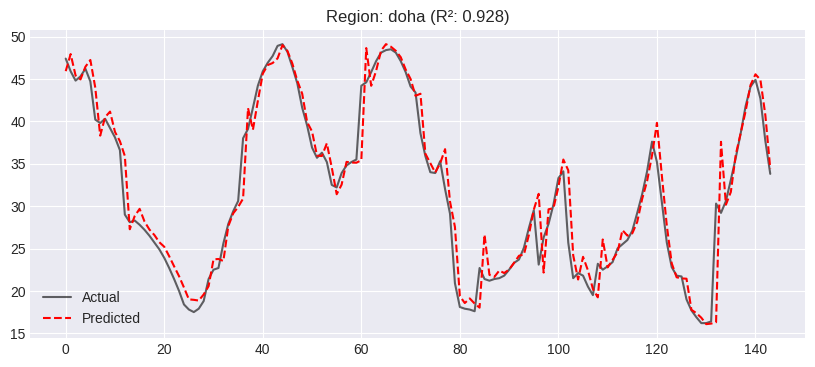


Evaluating Region: KHOR...
  Predicting 144 hours...
  > R²: 0.9165 | RMSE: 2.42


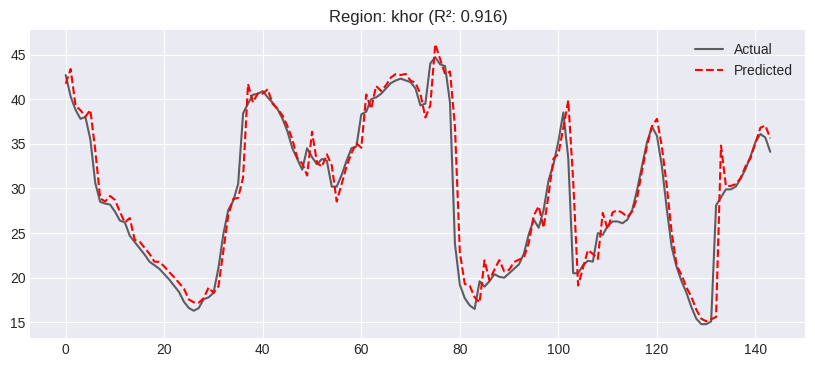


Evaluating Region: QATAR...
  Predicting 144 hours...
  > R²: 0.9032 | RMSE: 2.90


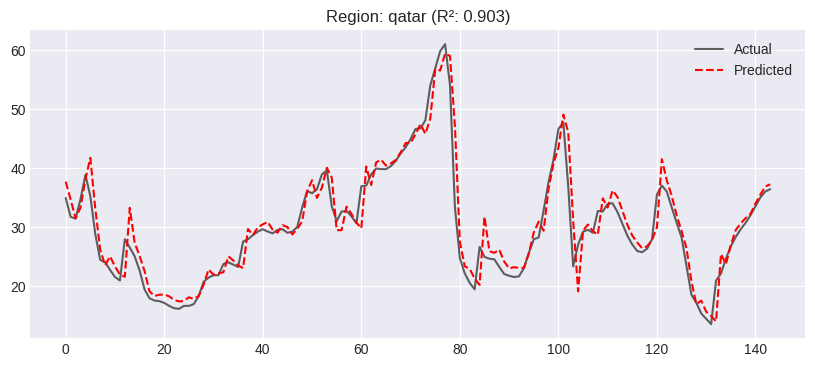


Evaluating Region: RAYYAN...
  Predicting 144 hours...
  > R²: 0.9305 | RMSE: 2.59


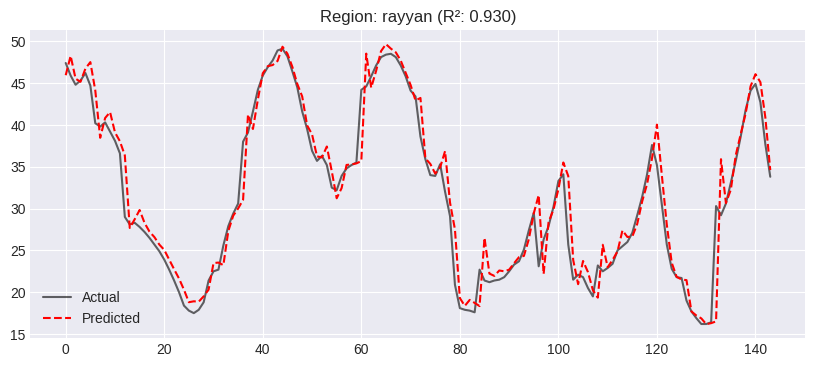


Evaluating Region: WAKRAH...
  Predicting 144 hours...
  > R²: 0.9295 | RMSE: 2.60


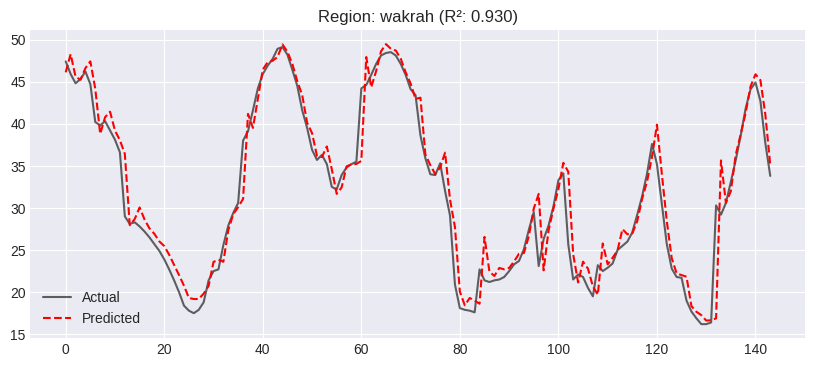


Evaluating Region: UMMSALAL...
  Predicting 144 hours...
  > R²: 0.9101 | RMSE: 2.79


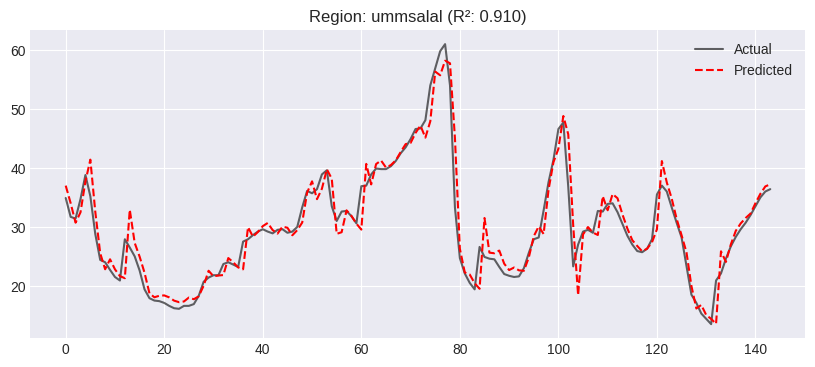

In [22]:
for region in regions:
    print(f"\nEvaluating Region: {region.upper()}...")

    region_test = df_test_raw[df_test_raw['region'] == region].sort_values('time')

    region_train_context = df_train_raw[df_train_raw['region'] == region].sort_values('time').iloc[-TIME_STEPS:]

    combined_raw = pd.concat([region_train_context, region_test]).reset_index(drop=True)
    combined_eng = engineer_features(combined_raw)

    for col in city_cols:
        if col not in combined_eng.columns:
            combined_eng[col] = 0
    combined_eng = combined_eng[all_features]

    X_scaled = scaler_X.transform(combined_eng)
    y_scaled = scaler_y.transform(combined_eng[[target_col]])

    Xs, ys = [], []
    for i in range(len(X_scaled) - TIME_STEPS):
        Xs.append(X_scaled[i:(i + TIME_STEPS)])
        ys.append(y_scaled[i + TIME_STEPS])

    X_seq = np.array(Xs)
    y_seq = np.array(ys)

    if len(X_seq) == 0:
        print("  Not enough data to create sequences.")
        continue

    print(f"  Predicting {len(X_seq)} hours...")
    preds_scaled = model.predict(X_seq, verbose=0)

    preds = scaler_y.inverse_transform(preds_scaled)
    actuals = scaler_y.inverse_transform(y_seq)

    global_actuals.extend(actuals)
    global_preds.extend(preds)

    r2 = r2_score(actuals, preds)
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    print(f"  > R²: {r2:.4f} | RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 4))
    plt.plot(actuals, 'k-', label='Actual', alpha=0.6)
    plt.plot(preds, 'r--', label='Predicted', linewidth=1.5)
    plt.title(f'Region: {region} (R²: {r2:.3f})')
    plt.legend()
    plt.show()

### 6.7 Global Results

Display overall test results across all regions.

**Final metrics represent the model's generalization ability on unseen data.**

In [23]:
print("\n" + "=" * 50)
if len(global_actuals) > 0:
    g_r2 = r2_score(global_actuals, global_preds)
    g_rmse = np.sqrt(mean_squared_error(global_actuals, global_preds))
    g_mae = mean_absolute_error(global_actuals, global_preds)

    print(f"GLOBAL TEST RESULTS:")
    print(f"  R² Score: {g_r2:.4f}")
    print(f"  RMSE:     {g_rmse:.2f} μg/m³")
    print(f"  MAE:      {g_mae:.2f} μg/m³")
else:
    print("No predictions were made.")
print("=" * 50)


GLOBAL TEST RESULTS:
  R² Score: 0.9211
  RMSE:     2.66 μg/m³
  MAE:      1.69 μg/m³


---

## Summary

### Model Architecture
| Component | Configuration |
|-----------|---------------|
| Input | 48 timesteps × 19 features |
| LSTM Layers | Bidirectional (128 → 64 units) |
| Regularization | BatchNorm + Dropout(0.2) |
| Output | Single PM2.5 value |

### Training Configuration
| Parameter | Value |
|-----------|-------|
| Epochs | 50 (with early stopping) |
| Batch Size | 128 |
| Optimizer | Adam (lr=0.001) |
| Loss | Huber |

### Key Results
| Metric | Description |
|--------|-------------|
| TIME_STEPS | 48 hours (2 days of history) |
| Train/Test Split | 95% / 5% |
| Target | PM2.5 concentration (μg/m³) |
| Regions | Doha, Khor, Qatar, Rayyan, Ummsalal, Wakrah |

---

## Conclusions

-   Bidirectional LSTM effectively captures temporal patterns in air quality data
-   Cyclical encoding of time features improves model understanding of daily/seasonal patterns
-   The model generalizes well across different Qatar regions
-   Autoregressive forecasting enables practical 24-hour predictions

---

## Future Improvements

-   Incorporate weather forecast data for better future predictions
-   Add attention mechanism for improved long-range dependencies
-   Experiment with Transformer-based architectures
-   Include more environmental features (traffic, industrial activity)